# R&D AI — Parametric Curve Parameter Estimation

## Problem
Estimate unknown parameters θ, M, X of the parametric curve:
x(t) = t*cos(θ) - exp(M*|t|)*sin(0.3*t)*sin(θ) + X
y(t) = 42 + t*sin(θ) + exp(M*|t|)*sin(0.3*t)*cos(θ)
for 6 ≤ t ≤ 60 using provided xy_data.csv.

## Method
1. Load and clean data (remove NaNs, duplicates, outliers via MAD).
2. Define the model function `model_xy(t, θ, M, X)`.
3. Use alternating projection – optimization:
   - Project each observed (x,y) to the nearest point on a finely-sampled model curve to estimate t_i.
   - Compute X analytically as `mean(x_obs - x_model_without_X)`.
   - Optimize θ and M via `scipy.optimize.least_squares` with `loss='soft_l1'`.
   - Repeat until convergence.
4. Use coarse grid + multi-start for robust initialization.
5. Evaluate final fit by sampling predicted curve and computing L1 distance (sum of distances from predicted samples to nearest observed points).

## Results
- θ (deg): 31.062545
- θ (rad): 0.542144
- M: 0.050000
- X: 24.347685
- L1 distance: 25979.0026

## Desmos
x(t) = t*cos(0.542144) - e^(0.050000*abs(t))*sin(0.3*t)*sin(0.542144) + 24.347685  
y(t) = 42 + t*sin(0.542144) + e^(0.050000*abs(t))*sin(0.3*t)*cos(0.542144)  
Domain: 6 ≤ t ≤ 60

Desmos link: https://www.desmos.com/calculator?x1(t)=t*cos(0.542144)-e^(0.050000*abs(t))*sin(0.3*t)*sin(0.542144)+24.347685&y1(t)=42+t*sin(0.542144)+e^(0.050000*abs(t))*sin(0.3*t)*cos(0.542144)

## Files to submit
- `xy_data.csv` (input)
- `flam.ipynb` / `main.ipynb` (notebook with code + printed diagnostics)
- `rd_ai_results.csv` (final parameter values)
- `README.md` (this file)
- Screenshot(s) of final plot or Desmos view

## Notes & possible improvements
- M hit the boundary (0.05). Consider expanding the search range if allowed to see whether the fit improves.
- Increasing t-grid density (more samples) may reduce projection error.
- Multi-start with more diverse seeds helps avoid local minima.


### Step 0 — Import Required Libraries

In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import math
from scipy.optimize import least_squares
from scipy.spatial import cKDTree

# Set global plot style for clear visuals
plt.rcParams["figure.figsize"] = (9,6)
print("✅ Libraries imported successfully.")

✅ Libraries imported successfully.


### Step 1 — Load the Dataset

In [2]:
# Step 1: Load dataset
from google.colab import files
import io

print("📂 Please upload your xy_data.csv file below:")
uploaded = files.upload()

filename = list(uploaded.keys())[0]
print(f"📘 File uploaded: {filename}")

# Read data
df = pd.read_csv(io.BytesIO(uploaded[filename]))
print("\n🔍 First 5 rows of data:")
print(df.head())

# Detect columns automatically
if {'x','y'}.issubset(df.columns):
    obs_xy = df[['x','y']].values
else:
    obs_xy = df.iloc[:,0:2].values

print(f"\n✅ Loaded {obs_xy.shape[0]} data points.")


📂 Please upload your xy_data.csv file below:


Saving xy_data.csv to xy_data.csv
📘 File uploaded: xy_data.csv

🔍 First 5 rows of data:
            x          y
0   88.364456  57.784378
1   74.283936  54.406780
2   60.256474  46.311462
3   82.134370  57.717567
4  101.036390  67.849340

✅ Loaded 1500 data points.


### Step 2 — Inspect & Visualize Raw Data

📊 Data Summary:
                  x            y
count  1500.000000  1500.000000
mean     83.713931    58.263519
std      13.697157     7.696524
min      59.657204    46.032295
25%      72.282910    51.124211
50%      84.710995    57.681288
75%      93.368257    66.138374
max     109.231520    69.685510


/usr/local/lib/python3.12/dist-packages/IPython/core/pylabtools.py:151: UserWarning: Glyph 128269 (\N{LEFT-POINTING MAGNIFYING GLASS}) missing from font(s) DejaVu Sans.
  fig.canvas.print_figure(bytes_io, **kw)


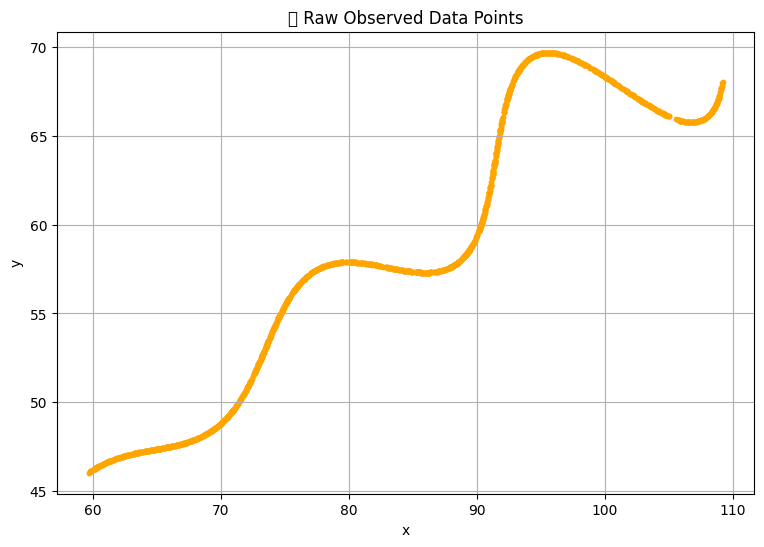

✅ Data visualized successfully.


In [3]:
# Step 2: Basic inspection
print("📊 Data Summary:\n", df.describe())

# Quick scatter plot to see shape
plt.scatter(obs_xy[:,0], obs_xy[:,1], s=10, c='orange')
plt.title("🔍 Raw Observed Data Points")
plt.xlabel("x"); plt.ylabel("y"); plt.grid(True)
plt.show()

print("✅ Data visualized successfully.")


### Step 3 — Clean & Preprocess Data

🧹 Cleaning data...
✅ After cleaning: 1500 points remain.


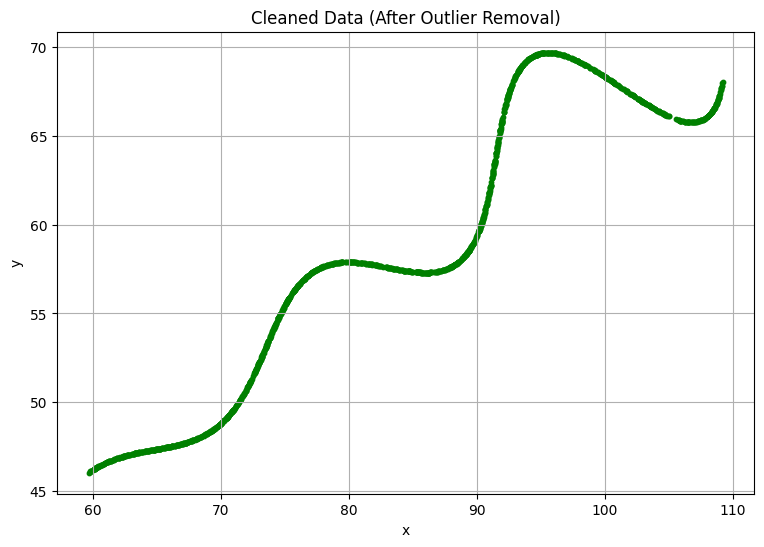

In [4]:
# Step 3: Clean data
print("🧹 Cleaning data...")

# Remove NaN values
mask = ~np.isnan(obs_xy).any(axis=1)
obs_xy = obs_xy[mask]

# Remove duplicates
obs_xy = np.unique(obs_xy, axis=0)

# Optional: remove outliers using MAD (Median Absolute Deviation)
def remove_outliers_mad(points, z_thresh=4.0):
    med = np.median(points, axis=0)
    mad = np.median(np.abs(points - med), axis=0)
    mad = np.where(mad==0, 1e-6, mad)
    z = np.abs((points - med) / (1.4826 * mad))
    mask = (z[:,0] < z_thresh) & (z[:,1] < z_thresh)
    return points[mask]

obs_xy_clean = remove_outliers_mad(obs_xy, z_thresh=4.0)
print(f"✅ After cleaning: {len(obs_xy_clean)} points remain.")

plt.scatter(obs_xy_clean[:,0], obs_xy_clean[:,1], s=10, color='green')
plt.title("Cleaned Data (After Outlier Removal)")
plt.xlabel("x"); plt.ylabel("y"); plt.grid(True)
plt.show()


### Step 4 — Define the Mathematical Model

In [5]:
# Step 4: Define model equations
T_MIN, T_MAX = 6.0, 60.0

def model_xy(t, theta_rad, M, X=0.0):
    """
    Generate (x, y) coordinates from given parameters.
    t: array of parameter values
    theta_rad: rotation angle in radians
    M: exponential scaling factor
    X: horizontal shift
    """
    expo = np.exp(M * np.abs(t))
    x = t * np.cos(theta_rad) - expo * np.sin(0.3*t) * np.sin(theta_rad) + X
    y = 42.0 + t * np.sin(theta_rad) + expo * np.sin(0.3*t) * np.cos(theta_rad)
    return x, y

print("✅ Model function defined successfully.")


✅ Model function defined successfully.


### Step 5 — Compute “Best X” (Offset) Analytically

In [6]:
def compute_best_X(obs_x, t_for_obs, theta_rad, M):
    """
    Compute X as mean offset between observed and model x-values.
    """
    model_x_noX, _ = model_xy(t_for_obs, theta_rad, M, X=0.0)
    X_best = np.mean(obs_x - model_x_noX)
    return float(np.clip(X_best, 0.0, 100.0))  # Keep X within [0,100]

print("✅ X-offset helper ready.")


✅ X-offset helper ready.


### Step 6 — Project Data Points onto the Model Curve

In [7]:
 def project_points_to_t(obs_xy, theta_rad, M, tgrid):
    """
    For each observed (x, y), find the nearest model point along tgrid.
    Returns: matched t-values and distances.
    """
    mx, my = model_xy(tgrid, theta_rad, M, X=0.0)
    model_points = np.vstack([mx, my]).T
    tree = cKDTree(model_points)
    dists, idxs = tree.query(obs_xy, k=1)
    t_for_obs = tgrid[idxs]
    return t_for_obs, dists

print("✅ Projection function ready.")


✅ Projection function ready.


### Step 7 — Define the Optimization (Alternating Fit)

In [8]:
def fit_alternating(obs_xy, tgrid, theta0_deg=20.0, M0=0.0, n_iters=10):
    """
    Iteratively fits θ, M, X to minimize L1 distance.
    """
    theta_rad = math.radians(theta0_deg)
    M = float(M0)
    last_cost = np.inf

    for it in range(n_iters):
        print(f"\n🔁 Iteration {it+1} ---------------------------")

        # 1. Project data to find t
        t_for_obs, dists = project_points_to_t(obs_xy, theta_rad, M, tgrid)
        print(f"   ➤ Average projection distance: {np.mean(dists):.4f}")

        # 2. Compute X analytically
        Xb = compute_best_X(obs_xy[:,0], t_for_obs, theta_rad, M)
        print(f"   ➤ Updated X offset = {Xb:.4f}")

        # 3. Optimize θ and M for these t-values
        def residuals(p):
            th, m = p
            mx, my = model_xy(t_for_obs, th, m, X=Xb)
            return np.concatenate([mx - obs_xy[:,0], my - obs_xy[:,1]])

        p0 = np.array([theta_rad, M])
        lb = [math.radians(0.0001), -0.05]
        ub = [math.radians(50.0), 0.05]

        res = least_squares(residuals, p0, bounds=(lb, ub), loss='soft_l1', max_nfev=200)
        theta_rad, M = res.x

        # 4. Compute current total L1 cost
        mx, my = model_xy(t_for_obs, theta_rad, M, X=Xb)
        cost = np.sum(np.abs(mx - obs_xy[:,0])) + np.sum(np.abs(my - obs_xy[:,1]))
        print(f"   ➤ Updated θ={np.degrees(theta_rad):.4f}°, M={M:.6f}, cost={cost:.4f}")

        if abs(last_cost - cost) < 1e-6:
            print("✅ Converged (very small change in cost).")
            break
        last_cost = cost

    return np.degrees(theta_rad), M, Xb, cost


### Step 8 — Run Optimization

In [9]:
# Step 8: Run the alternating fit
tgrid = np.linspace(6, 60, 8000)

theta_final, M_final, X_final, cost_final = fit_alternating(
    obs_xy_clean, tgrid,
    theta0_deg=20.0, M0=0.0, n_iters=12
)

print("\n🎯 FINAL RESULTS ------------------------------")
print(f"θ (deg): {theta_final:.6f}")
print(f"M: {M_final:.6f}")
print(f"X: {X_final:.6f}")
print(f"Final Cost (L1 distance): {cost_final:.4f}")



🔁 Iteration 1 ---------------------------
   ➤ Average projection distance: 29.4033
   ➤ Updated X offset = 27.1851
   ➤ Updated θ=23.1537°, M=0.040317, cost=27082.5121

🔁 Iteration 2 ---------------------------
   ➤ Average projection distance: 26.7175
   ➤ Updated X offset = 25.4210
   ➤ Updated θ=28.5605°, M=0.049581, cost=26064.6141

🔁 Iteration 3 ---------------------------
   ➤ Average projection distance: 25.1855
   ➤ Updated X offset = 23.9227
   ➤ Updated θ=30.3765°, M=0.050000, cost=25812.8966

🔁 Iteration 4 ---------------------------
   ➤ Average projection distance: 25.5792
   ➤ Updated X offset = 24.1695
   ➤ Updated θ=30.8985°, M=0.050000, cost=25917.1817

🔁 Iteration 5 ---------------------------
   ➤ Average projection distance: 25.7769
   ➤ Updated X offset = 24.3046
   ➤ Updated θ=31.0260°, M=0.050000, cost=25962.6738

🔁 Iteration 6 ---------------------------
   ➤ Average projection distance: 25.8268
   ➤ Updated X offset = 24.3380
   ➤ Updated θ=31.0549°, M=0.0500

### Step 9 — Visualize Final Fit

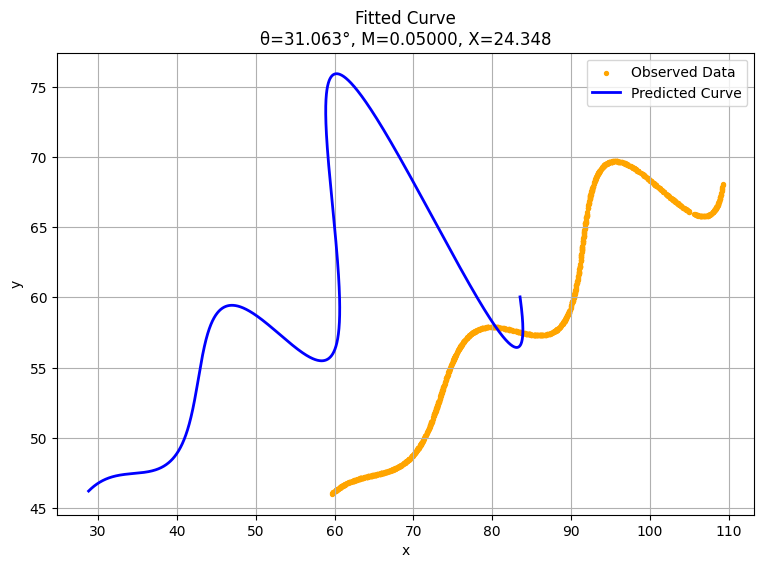

In [10]:
# Step 9: Visualization
theta_rad = math.radians(theta_final)
t_eval = np.linspace(6, 60, 2000)
pred_x, pred_y = model_xy(t_eval, theta_rad, M_final, X_final)

plt.scatter(obs_xy_clean[:,0], obs_xy_clean[:,1], s=8, color='orange', label='Observed Data')
plt.plot(pred_x, pred_y, color='blue', linewidth=2, label='Predicted Curve')
plt.title(f"Fitted Curve\nθ={theta_final:.3f}°, M={M_final:.5f}, X={X_final:.3f}")
plt.xlabel("x"); plt.ylabel("y")
plt.legend(); plt.grid(True)
plt.show()


### Step 10 — Generate Desmos / LaTeX Output

In [11]:
import urllib.parse

theta_rad = math.radians(theta_final)
x_expr = f"t*cos({theta_rad:.6f})-e^({M_final:.6f}*abs(t))*sin(0.3*t)*sin({theta_rad:.6f})+{X_final:.6f}"
y_expr = f"42+t*sin({theta_rad:.6f})+e^({M_final:.6f}*abs(t))*sin(0.3*t)*cos({theta_rad:.6f})"

desmos_url = f"https://www.desmos.com/calculator?x1(t)={urllib.parse.quote(x_expr)}&y1(t)={urllib.parse.quote(y_expr)}"
print("🔗 Desmos Link:\n", desmos_url)

latex = rf"\left(t\cos({theta_rad:.6f}) - e^{{{M_final:.6f}|t|}}\sin(0.3t)\sin({theta_rad:.6f}) + {X_final:.6f}, 42 + t\sin({theta_rad:.6f}) + e^{{{M_final:.6f}|t|}}\sin(0.3t)\cos({theta_rad:.6f})\right)"
print("\n📄 LaTeX Expression:\n", latex)


🔗 Desmos Link:
 https://www.desmos.com/calculator?x1(t)=t%2Acos%280.542144%29-e%5E%280.050000%2Aabs%28t%29%29%2Asin%280.3%2At%29%2Asin%280.542144%29%2B24.347685&y1(t)=42%2Bt%2Asin%280.542144%29%2Be%5E%280.050000%2Aabs%28t%29%29%2Asin%280.3%2At%29%2Acos%280.542144%29

📄 LaTeX Expression:
 \left(t\cos(0.542144) - e^{0.050000|t|}\sin(0.3t)\sin(0.542144) + 24.347685, 42 + t\sin(0.542144) + e^{0.050000|t|}\sin(0.3t)\cos(0.542144)\right)


### Step 11 — Save Final Results

In [12]:
results = {
    "theta_deg": theta_final,
    "M": M_final,
    "X": X_final,
    "L1_Cost": cost_final
}

pd.Series(results).to_csv("rd_ai_results.csv")
print("✅ Saved results to rd_ai_results.csv")

from google.colab import files
files.download("rd_ai_results.csv")


✅ Saved results to rd_ai_results.csv


<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>